# The CNS North Korea Missile Test Database

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_grid as altgrid
import numpy as np
import us
import urllib.request, json
import glob
import os
import requests
from bs4 import BeautifulSoup
import os
import time
import matplotlib.pyplot as plt
import squarify
from matplotlib.pyplot import figure

In [3]:
alt.themes.register("grid", altgrid.theme)
alt.themes.enable("grid")
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

## Read data

#### Get [list](https://missilethreat.csis.org/country/dprk/) of North Korean missiles from CSIS

In [5]:
my_headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OSX 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko)Chrome/71.0.3578.98 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
}

In [6]:
missiles_url = "https://missilethreat.csis.org/country/dprk"
page = requests.get(missiles_url, headers=my_headers).content

In [7]:
missile_df = pd.read_html(page)[0].rename(
    columns={
        "Missile Name": "name",
        "Class": "class",
        "Range": "range",
        "Status": "status",
    }
)

In [8]:
missile_df["max_range_km"] = (
    missile_df["range"]
    .str.split(" - ")
    .str[-1]
    .str.replace(" km", "")
    .str.replace(",", "", regex=False)
    .str.replace("+", "", regex=False)
)

In [9]:
missile_df

,name,class,range,status,max_range_km
0,BM-25 Musudan,IRBM,"2,500 - 4,000 km",In Development,4000
1,Hwasong-12,IRBM,"4,500 km",In Development,4500
2,Hwasong-13,ICBM,"5,500 - 11,500 km",Never Deployed,11500
3,Hwasong-14,ICBM,"10,400 km",Operational,10400
4,Hwasong-15,ICBM,"8,500 - 13,000 km",In Development,13000
5,Hwasong-5,SRBM,300 km,Operational,300
6,Hwasong-6,SRBM,500 km,Operational,500
7,Hwasong 7 (Nodong 1),MRBM,"1,200 - 1,500 km",Operational,1500
8,Hwasong-9,MRBM,"800 - 1,000 km",Operational,1000
9,KN-01,ASCM,110 - 160 km,Operational,160


---

## Launches

#### Download latest version of the Nuclear Threat Initiative database [here](https://beyondparallel.csis.org/database-north-korean-provocations/)

In [10]:
url = "https://www.nti.org/wp-content/uploads/2021/10/north_korea_missile_test_database_current-for-website.xlsx"

In [11]:
resp = requests.get(url)
output = open("data/raw/north_korea_missile_test_database.xls", "wb")
output.write(resp.content)
output.close()

#### Read data

In [12]:
src = pd.read_excel(
    "data/raw/north_korea_missile_test_database.xls", skiprows=1, parse_dates=["Date"]
).sort_values("Date", ascending=False)[
    [
        "Date",
        "Date Entered/Updated",
        "Launch Time (UTC)",
        "Missile Name",
        "Missile Type",
        "Facility Name",
        "Facility Location",
        "Facility Latitude",
        "Facility Longitude",
        "Landing Location",
        "Apogee",
        "Distance Travelled",
        "Confirmation Status",
        "Test Outcome",
        "Additional Information",
        "Source(s)",
    ]
]

In [13]:
src.columns = (
    src.columns.str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("/", "_", regex=False)
)

#### Dates

In [14]:
src["year"] = src["date"].dt.year.astype(str)
src["month"] = src["date"].dt.month
src["day"] = src["date"].dt.day
src["day"] = src["date"].dt.day_name()

In [15]:
type_lookup = {
    "SRBM": "Short-range",
    "MRBM": "Medium-range",
    "SLV": "Satellite launch vehicle",
    "SLBM": "Submarine-launched",
    "Unknown": "Unknown",
    "IRBM": "Intermediate-range",
    "ICBM": "Intercontinental",
    "HGV": "Hypersonic glide vehicle",
}

In [16]:
src["missle_type_desc"] = src["missile_type"].map(type_lookup)

In [17]:
df = src[
    (src["missile_name"] != "Unknown") & (src["missile_type"].str.contains("BM"))
].copy()

In [18]:
df["facility_location"] = (
    df["facility_location"].str.replace(", (North Korea)", "", regex=False).str.title()
)

In [19]:
df = df[(df["facility_latitude"] != "Unknown") & (df["test_outcome"] != "Failure")]

In [20]:
df.head()

,date,date_entered_updated,launch_time_(utc),missile_name,missile_type,facility_name,facility_location,facility_latitude,facility_longitude,landing_location,apogee,distance_travelled,confirmation_status,test_outcome,additional_information,source(s),year,month,day,missle_type_desc
202,2022-10-08,2022-10-10,16:53:00,KN-25,SRBM,Munchon,"Munchon, Kangwong Province",39.2815,127.377,Sea of Japan or East Sea,90 km,350 km,Confirmed,Success,2 of 2 tests,https://en.yna.co.kr/view/AEN20221009000354325...,2022,10,Saturday,Short-range
201,2022-10-08,2022-10-10,16:47:00,KN-25,SRBM,Munchon,"Munchon, Kangwong Province",39.2815,127.377,Sea of Japan or East Sea,90 km,350 km,Confirmed,Success,"On October 9 (local time), North Korea launche...",https://en.yna.co.kr/view/AEN20221009000354325...,2022,10,Saturday,Short-range
200,2022-10-05,2022-10-06,21:15:00,KN-23,SRBM,Samsok,"Samsok District, Pyongyang",39.1268,125.9579,Sea of Japan or East Sea,50 km,800 km,Confirmed,Success,2 of 2 tests,https://en.yna.co.kr/view/AEN20221006000853325...,2022,10,Wednesday,Short-range
199,2022-10-05,2022-10-06,21:00:00,KN-25,SRBM,Samsok,"Samsok District, Pyongyang",39.1268,125.9579,Sea of Japan or East Sea,100 km,350 km,Confirmed,Success,"Less than 24 hours after the IRBM launch, Nort...",https://en.yna.co.kr/view/AEN20221006000853325...,2022,10,Wednesday,Short-range
198,2022-10-03,2022-10-06,22:22:00,New IRBM (2022),IRBM,Mupyong-ni Arms Plant,"Mup'Yong-Ni, Chagang Province",40.611208,126.425743,Pacific Ocean,970 km,4500 km,Confirmed,Success,"At 7:22 AM local time on 4 October 2022, North...",https://en.yna.co.kr/view/AEN20221004001354325...,2022,10,Monday,Intermediate-range


In [21]:
df["decade"] = df["year"].str[:3] + "0s"

#### Create a geodataframe

In [22]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.facility_longitude, df.facility_latitude)
)

In [23]:
launches_grouped = (
    gdf.groupby(
        [
            # "decade",
            "facility_longitude",
            "facility_latitude",
            "facility_name",
            "facility_location",
        ]
    )
    .size()
    .reset_index(name="count")
    .rename(
        columns={"facility_longitude": "longitude", "facility_latitude": "latitude"}
    )
    .sort_values("count", ascending=False)
)

In [24]:
launches_counts_gdf = gpd.GeoDataFrame(
    launches_grouped,
    geometry=gpd.points_from_xy(launches_grouped.longitude, launches_grouped.latitude),
)

<AxesSubplot:>

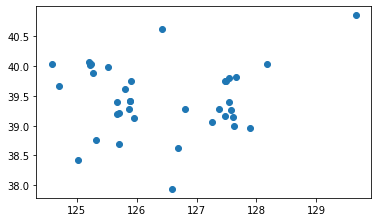

In [25]:
launches_counts_gdf.plot()

---

## Aggregate

#### Missiles by year

In [26]:
missile_total = df.groupby(["year"])["date"].count().reset_index(name="count")

In [27]:
missile_total.head()

,year,count
0,1984,3
1,1990,1
2,1991,1
3,1993,4
4,2006,6


#### Fill in missing years 

In [28]:
dummy = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vT1tUkO4UkOeOl5_O_j5yEHplUJF1NLC1u55kCWg_1HsbTputy80dZJubTzCdHCKPmTgMS8V9KS6cmM/pub?gid=687150892&single=true&output=csv",
    dtype={"year": str},
)

In [29]:
missile_total_all = pd.merge(missile_total, dummy, on=["year"], how="right").fillna(0)

In [30]:
bars = (
    alt.Chart(missile_total_all)
    .mark_bar()
    .encode(
        x=alt.X(
            "year:N",
            axis=alt.Axis(
                values=["1960", "1970", "1980", "1990", "2000", "2010", "2022"],
            ),
            title="",
        ),
        y=alt.Y("count:Q", axis=alt.Axis(tickCount=6), title=""),
    )
)

# text = bars.mark_text(
#     align="left",
#     baseline="middle",
#     dx=-6,
#     dy=-8,
# ).encode(text="count:Q")

(bars).properties(
    height=300,
    width=650,
    title="North Korea successful ballistic missile launches, by year",
)

alt.Chart(...)

#### Missile types, by year

In [43]:
missile_types_src = (
    df.groupby(["year", "missile_type", "missle_type_desc"])["date"]
    .count()
    .reset_index(name="count")
)

In [46]:
missile_types_src.head()

In [57]:
dummy2 = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vT1tUkO4UkOeOl5_O_j5yEHplUJF1NLC1u55kCWg_1HsbTputy80dZJubTzCdHCKPmTgMS8V9KS6cmM/pub?gid=2045819622&single=true&output=csv",
    dtype={"year": str},
)

In [59]:
missile_total_all = pd.merge(
    missile_types_src,
    dummy2,
    on=["year", "missle_type_desc", "missile_type"],
    how="right",
).fillna(0)

In [61]:
missile_total_all.head()

,year,missile_type,missle_type_desc,count
0,1960,IRBM,Intermediate-range,0.0
1,1961,IRBM,Intermediate-range,0.0
2,1962,IRBM,Intermediate-range,0.0
3,1963,IRBM,Intermediate-range,0.0
4,1964,IRBM,Intermediate-range,0.0


In [33]:
missile_treemap = (
    df.groupby(["year", "missile_type", "missle_type_desc"])["date"]
    .count()
    .reset_index(name="count")
).sort_values("missle_type_desc")

In [34]:
thisyear = missile_treemap[missile_treemap["year"] == "2022"]

In [35]:
otheryears = (
    missile_treemap[missile_treemap["year"] != "2022"]
    .groupby(["missle_type_desc"])["count"]
    .sum()
    .reset_index()
    .sort_values("missle_type_desc")
)

In [36]:
otheryears

,missle_type_desc,count
0,Intercontinental,3
1,Intermediate-range,4
2,Medium-range,21
3,Short-range,89
4,Submarine-launched,5


In [37]:
thisyear

,year,missile_type,missle_type_desc,count
27,2022,ICBM,Intercontinental,1
28,2022,IRBM,Intermediate-range,2
29,2022,MRBM,Medium-range,2
31,2022,SRBM,Short-range,18
30,2022,SLBM,Submarine-launched,1


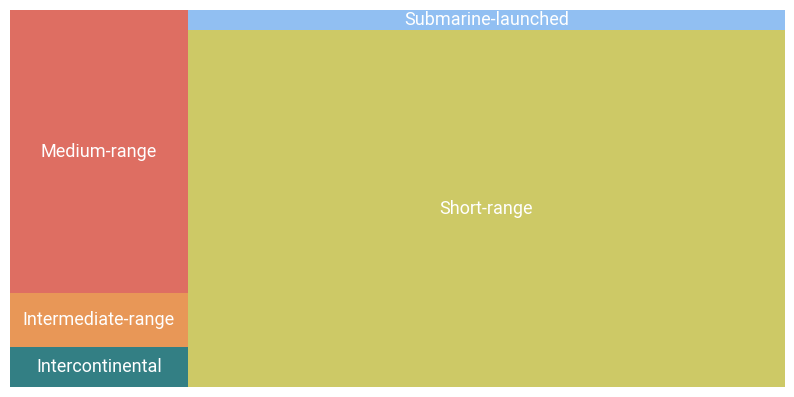

In [38]:
figure(figsize=(10, 5), dpi=100)

squarify.plot(
    sizes=otheryears["count"],
    label=otheryears["missle_type_desc"],
    color=[
        "#005f66",
        "#e37e2d",
        "#d64a3b",
        "#c1bc40",
        "#76b0ef",
    ],
    alpha=0.8,
    text_kwargs={"fontsize": 13, "color": "#ffffff", "fontfamily": "Roboto"},
)
plt.axis("off")
plt.show()

In [39]:
missile_types["missile_type"].value_counts()

SRBM    15
MRBM     7
SLBM     5
IRBM     3
ICBM     2
Name: missile_type, dtype: int64

---

In [81]:
circles = (
    alt.Chart(missile_total_all[missile_total_all["year"] > "1979"])
    .mark_circle(opacity=0.6, stroke="#1a1a1a", strokeWidth=0)
    .encode(
        alt.X(
            "year:O",
            axis=alt.Axis(
                values=["1960", "1970", "1980", "1990", "2000", "2010", "2022"],
            ),
            title=" ",
        ),
        alt.Y("missle_type_desc:N", title=" "),
        alt.Size(
            "count:Q",
            title="Missle count",
            scale=alt.Scale(range=[0, 2000]),
            # legend=None,
        ),
        alt.Color("missile_type:N", legend=None),
    )
)

text = (
    alt.Chart(missile_total_all)
    .mark_text(dx=0, dy=0, color="white")
    .encode(
        x=alt.X("year:O", stack="zero"),
        y=alt.Y("missle_type_desc:O"),
        text=alt.Text("count:Q"),
    )
)

(circles).configure_legend(symbolType="circle").properties(
    width=650,
    height=200,
    title="North Korea ballistic missile launches, by type, count and year",
)

alt.Chart(...)

---

## Exports

In [41]:
launches_grouped.to_csv("data/processed/launches_grouped_location.csv", index=False)

In [42]:
launches_counts_gdf.to_file(
    "data/processed/launches_counts_gdf.geojson", driver="GeoJSON"
)

/Users/stiles/.pyenv/versions/3.9.9/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [165]:
scaramucci = 11

In [166]:
df = pd.read_html(
    "https://en.wikipedia.org/wiki/List_of_prime_ministers_of_the_United_Kingdom_by_length_of_tenure"
)[0]

In [167]:
df[["years", "days"]] = df["Tenure length"].str.split(", ", expand=True)

In [168]:
df["years"] = (
    df["years"]
    .str.replace("years", "")
    .str.replace("days", "")
    .str.replace("year", "")
    .str.replace("days", "", regex=False)
    .str.replace("(outgoing)", "", regex=False)
).astype(int)

In [169]:
df["days"] = df["days"].str.replace("days", "").fillna(0).astype(int)

In [170]:
df.loc[df["years"] > 20, "days"] = df["years"]
df.loc[df["years"] > 20, "years"] = 0

In [172]:
df.tail()

,Rank,Prime Minister,Tenure length,Termsα,Party,Start,Reasonfor exit,Ref.,years,days
51,52,The Duke of Devonshire,225 days,1,Whig,1756,Replaced,[1],0,225
52,53,Bonar Law,211 days,1,Conservative (Scot. Unionist),1922,Illness,[1],0,211
53,54,The Viscount Goderich,144 days,1,Tory (Canningite),1827,Replaced,[1],0,144
54,55,George Canning,119 days,1,Tory (Canningite),1827,Died,[1],0,119
55,56,Liz Truss,44 days(outgoing),1,Conservative,2022,Resigned,[1][6],0,44


In [173]:
df["total_days"] = (df["years"] * 365.25) + df["days"]

In [177]:
df["scaramuccis"] = (df["total_days"] / scaramucci).round(2)

In [180]:
df.columns = df.columns.str.lower().str.replace(" ", "_", regex=False)

In [187]:
df = df[
    [
        "rank",
        "prime_minister",
        "party",
        "start",
        "reasonfor_exit",
        "years",
        "days",
        "total_days",
        "scaramuccis",
    ]
]

In [188]:
df.head()

,rank,prime_minister,party,start,reasonfor_exit,years,days,total_days,scaramuccis
0,1,Sir Robert Walpole,Whig,1721,Resigned,20,314,7619.00,692.64
1,2,William Pitt the Younger,Tory (Pittite),1783,Died,18,343,6917.50,628.86
2,3,The Earl of Liverpool,Tory (Pittite),1812,Illness,14,305,5418.50,492.59
3,4,The Marquess of Salisbury,Conservative,1885,Illness,13,252,5000.25,454.57
4,5,William Ewart Gladstone,Liberal,1868,Resigned,12,126,4509.00,409.91


In [189]:
df.tail()

,rank,prime_minister,party,start,reasonfor_exit,years,days,total_days,scaramuccis
51,52,The Duke of Devonshire,Whig,1756,Replaced,0,225,225.0,20.45
52,53,Bonar Law,Conservative (Scot. Unionist),1922,Illness,0,211,211.0,19.18
53,54,The Viscount Goderich,Tory (Canningite),1827,Replaced,0,144,144.0,13.09
54,55,George Canning,Tory (Canningite),1827,Died,0,119,119.0,10.82
55,56,Liz Truss,Conservative,2022,Resigned,0,44,44.0,4.00
